In [142]:
import numpy as np
import joypy
from matplotlib import pyplot as plt
from matplotlib import cm

from scipy import ndimage as ndi
from scipy.spatial import distance

from skimage import io
from skimage.color import rgb2gray
from scipy import ndimage
from skimage import filters
from skimage.morphology import disk, ball

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2


In [2]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'

path='images'

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)

In [3]:
def img_show(image,N=20,cmap=plt.cm.nipy_spectral):
    
    plt.figure(figsize=(N,N))
    plt.axis('off')
    plt.imshow(image,cmap=cmap)
    plt.show()

def imdivide(image,side):
    
    width,height = image.size
    sides={'left':0,'right':1}
    shape=[(0,0,width//2,height),(width//2,0,width,height)]
    return image.crop(shape[sides[side]])

def combine(image,k=0.5,N=20): 
    left_img=imdivide(image,'left')
    right_img=imdivide(image,'right')

    l=k
    r=1-l
    gray=np.array(left_img)*l
    gray+=np.array(right_img)*r
    gray=gray.astype('uint8')
    return gray

def do_otsu(img,N=20):
    image=rgb2gray(img)
    
    global_thresh=filters.threshold_otsu(image)
    binary_global = image > global_thresh
    
    return binary_global

## Выделение пустот

denoised=mean_filter(image)

binary=otsu(denoised)

grad=gradient(binary)

bin_grad=-binary+grad

In [4]:
combined1=combine(grain1_pil,0.5,10)
combined2=combine(grain2_pil,0.5,10)
combined3=combine(grain3_pil,0.5,10)

denoised1 = filters.rank.median(combined1, disk(3))
denoised2 = filters.rank.median(combined2, disk(3))
denoised3 = filters.rank.median(combined3, disk(3))

binary1=do_otsu(denoised1).astype('uint8')
binary2=do_otsu(denoised2).astype('uint8')
binary3=do_otsu(denoised3).astype('uint8')

grad1 = filters.rank.gradient(binary1, disk(1))
grad2 = filters.rank.gradient(binary2, disk(1))
grad3 = filters.rank.gradient(binary3, disk(1))

# у зерен значение пикселя - 0, у тела пустоты - 1, у границы пустоты - 2
bin_grad1=1-binary1+grad1
bin_grad2=1-binary2+grad2
bin_grad3=1-binary3+grad3

image1=(bin_grad1>0).astype('uint8')*255
image2=(bin_grad2>0).astype('uint8')*255
image3=(bin_grad3>0).astype('uint8')*255

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:27: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


In [5]:
#io.imsave('bin_grad.png',image)

## Маркировка углов

http://espressocode.top/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/

classes - каждому пикселю дается свой класс, по картинке гуляет матрица свертки

In [5]:
def mark_corners(image):
    image=copy.copy(image)
    corners = cv2.goodFeaturesToTrack(image, 1000000, 0.1, 10)

    corners = np.int0(corners)
    print('number of corners: ',len(corners))
    for i in corners:
        x, y = i.ravel()
        cv2.circle(image, (x, y), 3, 255, -1)
    x=copy.copy(corners[:,0,1])
    y=copy.copy(corners[:,0,0])
    corners[:,0,0],corners[:,0,1]=x,y
    return image,corners.astype('int64')

def mark_classes(image):
    classes = filters.rank.gradient(image, disk(1)) < 250
    classes,num = ndi.label(classes)
    print('number of classes:',num)
    return classes,num

In [6]:
grain1_marked,grain1_corners=mark_corners(image1)
grain2_marked,grain2_corners=mark_corners(image2)
grain3_marked,grain3_corners=mark_corners(image3)

grain1_classes,class1_num=mark_classes(image1)
grain2_classes,class2_num=mark_classes(image2)
grain3_classes,class3_num=mark_classes(image3)

number of corners:  303
number of corners:  1388
number of corners:  4222
number of classes: 196
number of classes: 342
number of classes: 1244


## Дадим каждой вершине привязку к пустоте

In [7]:
def join_corners2classes(classes,classes_num,corners,max_corners_per_class):

    shape=(classes_num+1,max_corners_per_class)
    nodes=np.zeros(shape,dtype='int64')
    r=2
    for i,corner in enumerate(corners):
        x=corner[0][0]
        y=corner[0][1]
        cls=classes[x,y]
        real_cls=0
        flag=True
        x_lin=range(x-r,x+r)
        y_lin=range(y-r,y+r)
        while flag:
            for xi in x_lin:
                for yi in y_lin:
                    if classes[xi,yi]!=0 and classes[xi,yi]!=1 and classes[xi,yi]!=2:
                        real_cls=classes[xi,yi]
                        flag=False
                    elif yi==y_lin[-1] and xi==x_lin[-1]:
                        flag=False
                    else:
                        continue 

        index=nodes[real_cls,-1]
        nodes[real_cls,index]=i
        nodes[real_cls,-1]+=1
    return nodes

In [8]:
nodes1=join_corners2classes(grain1_classes,
                             class1_num,
                             grain1_corners,
                             100)

nodes2=join_corners2classes(grain2_classes,
                             class2_num,
                             grain2_corners,
                             500)

nodes3=join_corners2classes(grain3_classes,
                             class3_num,
                             grain3_corners,
                             500)

## Визуализируем графы каждой пустоты

In [9]:
for node in nodes[2:].astype('int64'):
    indeces=[]
    for index in node:
        if index!=0:
            indeces.append(index)
    cls_corners=corners[indeces]
    for corner1 in cls_corners:
        for corner2 in cls_corners:
            x1=corner1[0][0]
            y1=corner1[0][1]
            x2=corner2[0][0]
            y2=corner2[0][1]
            draw.line((y1,x1,y2,x2), fill=(185), width=1)
                
test_image.save('edge.jpg')

NameError: name 'nodes' is not defined

## Подсчитаем количество углов у пустот

In [10]:
def show_corners_classes(nodes,classes,N=2000): 
    node_corner_numbers=np.zeros((classes.shape[0],1))
    for i,node in enumerate(nodes):
        for corner in node:
            if corner:
                node_corner_numbers[i]+=1

    std=node_corner_numbers.std(axis=0)[0]
    mean=node_corner_numbers.mean(axis=0)[0]

    print('std: ',round(std,3))
    print('mean: ',round(mean,3))
    print('number of classes: ',classes.shape[0])
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('Количество углов у пустоты',size=20)
    ax.set_xlabel('Порядковый номер пустоты',size=20)
    plt.plot(node_corner_numbers[:N])

std:  4.064
mean:  3.231
number of classes:  1671


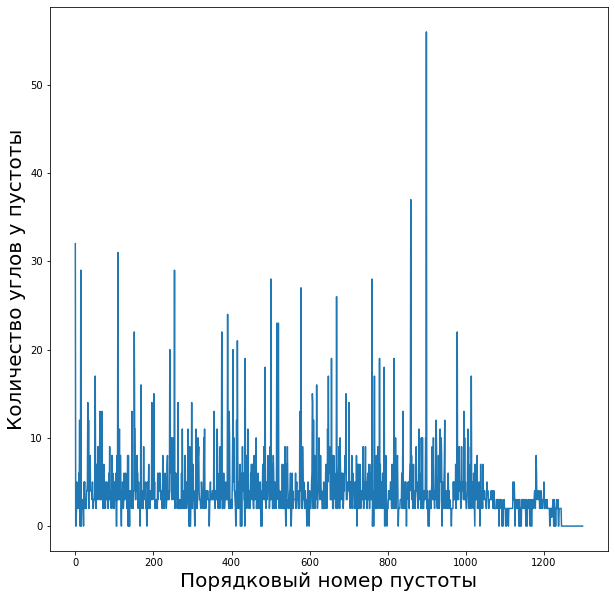

In [11]:
N=1300
show_corners_classes(nodes3,grain3_classes,N)

## Подсчитаем количество пустот, в которые входит угол

In [12]:
def show_classes_corners(nodes,corners,N=2000):   
    corner_distr=np.zeros((corners.shape[0]))
    
    for i in range(corners.shape[0]):
        for node in nodes:
            if i in node:
                corner_distr[i]+=1
                
    std=corner_distr.std(axis=0)
    mean=corner_distr.mean(axis=0)

    print('std: ',round(std,3))
    print('mean: ',round(mean,3))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('Количество вхождений в пустоту',size=20)
    ax.set_xlabel('Порядковый номер угла',size=20)
    plt.plot(corner_distr[:N])
    plt.show()

std:  9.765
mean:  1.484


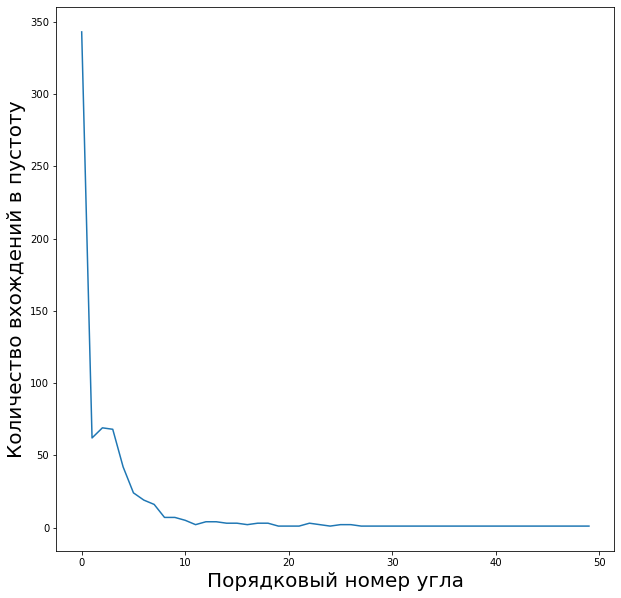

In [13]:
k=50
show_classes_corners(nodes2,grain2_corners,k)

## Соединим углы пустоты по периметру

In [15]:
def mean_pixel(image,point1,point2,r):
    val=0
    num=0
    image=rgb2gray(image)
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]

    # идем всегда из х1 в х2, сверху вниз
    if x1>x2:
        x1,y1,x2,y2=x2,y2,x1,y1

    y_lin=[]
    x_lin=range(x1,x2)
    # проведем линию и сохраним ее координаты
    for xi in x_lin:
        y_lin.append(round(((xi-x1)/(x2-x1))*(y2-y1)+y1))
    # координатная ось повернута на -90 градусов
    # новый х=-y, новый y=x

    x_lin=np.array(x_lin,dtype='int64')
    y_lin=np.array(y_lin,dtype='int64')
    for xi,yi in zip(y_lin,x_lin):
        for x in range(xi-r,xi+r):
            for y in range(yi-r,yi+r):

                val+=image[y,x]
                num+=1
    if num==0:
        mean=0
    else:
        mean=abs(((val/num)/255)-0.5)
    
    dist=distance.euclidean(point1,point2)
        
    return round(mean*dist,3)

In [19]:
def estimate_edges(image,node,corners,position=0,radius=2):
    # вычисление расстояния и среднего значения между 
    # точкой с индексом posion и остальными точками пустоты
    v1=node[position]
    vals=np.zeros((len(node),2))
    if v1!=0:
        for i,v2 in enumerate(node):

            if v2!=0 and v1!=v2  :
                vals[i,0]=v2
                point1=corners[v1]
                point2=corners[v2]
                k=mean_pixel(image,point1[0],point2[0],radius)
                vals[i,1]=k
    return vals
        

In [138]:
def sort_perimetr(image,nodes,corners,radius=5):
    new_nodes=np.zeros(nodes.shape,dtype='int64')
    
    # проходим по каждой пустоте
    for i,orig_node in enumerate(nodes):
    # node - пустота
        v1_index=0
        v1=orig_node[v1_index] # фиксируем первый угол и затем будем считать относительно него
        step=1
        new_nodes[i,0]=v1
        flag=True
        
        orig_node_len=orig_node[-1]
        node=list(copy.copy(orig_node[:orig_node_len]))
        
        print('old_node',orig_node[:orig_node_len])
        print('change node',node)
        print('i=',i)
        print('-------------')
        if v1!=0 and len(node)>1:
            while flag:
 
          #      print('change node',node)
          #      print('new_node',new_nodes[i,: orig_node_len])
                    
          #      print('v1_index',v1_index)
          #      print('v1',v1)
                vals=estimate_edges(image, node,corners,position=v1_index,radius=radius)
               # print('vals',vals)
                non_zero_indeces=np.where((vals[:,0][:node[-1]]!=0) )[0]
                vals=vals[non_zero_indeces]
            #    print(vals)
                min_val=vals.min(axis=0)[1]
                
                v2_vals_index=np.where(vals[:,1]==min_val )[0][0]
                v2=vals[v2_vals_index][0]
                v2_index=np.where(node==v2)[0][0]

            #    print('v2',v2)
            #    print('v2_index old',v2_index)
                new_nodes[i,step]=v2
                node.pop(v1_index)
                
                v1=v2
                v2_index=node.index(v2)
                v1_index=v2_index
                
            #    print('v2_index new',v2_index)

             #   print('--------------')
                
                step+=1
                if step==orig_node_len:
                    print('new_node',new_nodes[i,: orig_node_len])
                    print('===============')
                    flag=False
               
        else:
            continue
        new_nodes[i,-1]= orig_node_len
    return new_nodes

In [146]:
type(image2)

numpy.ndarray

In [149]:
image=image2
N=212
max_dist=80
# 46
radius=5
img=Image.fromarray(np.uint8(cm.gist_earth(image)*255))
image = ImageOps.expand(img,border=radius,fill='black')
image=np.array(image)

#vals=estimate_edges(image,nodes[N],corners,position=position,radius=5)

#img=draw_edges(image,position,node.astype('int64'),vals,corners,max_dist)
i=4

new_nodes=sort_perimetr(image,nodes2,grain2_corners,radius=radius)

#img_show(img,cmap='gray',N=12)
#io.imsave('vals.png',img)

old_node [  26  153  276  344  449  451  452  453 1131 1333]
change node [26, 153, 276, 344, 449, 451, 452, 453, 1131, 1333]
i= 0
-------------


C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  after removing the cwd from sys.path.


new_node [  26  276 1333  451  452 1131  453  449  344  153]
old_node []
change node []
i= 1
-------------
old_node []
change node []
i= 2
-------------
old_node [  92  152  259  270  444  764 1113 1115 1116 1122 1126 1325 1326 1327
 1334 1336 1383 1384]
change node [92, 152, 259, 270, 444, 764, 1113, 1115, 1116, 1122, 1126, 1325, 1326, 1327, 1334, 1336, 1383, 1384]
i= 3
-------------
new_node [  92  270 1336 1126  152 1334  764 1116  444 1122 1384 1383 1115 1325
 1327 1326 1113  259]
old_node [1135]
change node [1135]
i= 4
-------------
old_node []
change node []
i= 5
-------------
old_node [  91  154  253  260  266  343  448  602  603  763  766 1114 1118 1127
 1328 1330 1382]
change node [91, 154, 253, 260, 266, 343, 448, 602, 603, 763, 766, 1114, 1118, 1127, 1328, 1330, 1382]
i= 6
-------------
new_node [  91  343  763  448 1127  766  260  154  266  602  253 1118 1328 1330
  603 1382 1114]
old_node [ 446  765 1120 1133 1134 1386 1387]
change node [446, 765, 1120, 1133, 1134, 1386, 1

new_node [ 429 1064 1072 1073]
old_node [ 18 144]
change node [18, 144]
i= 66
-------------
new_node [ 18 144]
old_node [ 335  588 1070]
change node [335, 588, 1070]
i= 67
-------------
new_node [ 335 1070  588]
old_node [1071 1294 1296]
change node [1071, 1294, 1296]
i= 68
-------------
new_node [1071 1294 1296]
old_node []
change node []
i= 69
-------------
old_node [ 433  434  436 1295]
change node [433, 434, 436, 1295]
i= 70
-------------
new_node [ 433  434 1295  436]
old_node [ 334  747 1069]
change node [334, 747, 1069]
i= 71
-------------
new_node [ 334 1069  747]
old_node [  79  435  587 1038 1293 1376]
change node [79, 435, 587, 1038, 1293, 1376]
i= 72
-------------
new_node [  79 1038 1293  587 1376  435]
old_node [ 432 1067]
change node [432, 1067]
i= 73
-------------
new_node [ 432 1067]
old_node [ 143  234 1066 1068 1291]
change node [143, 234, 1066, 1068, 1291]
i= 74
-------------
new_node [ 143 1068 1066 1291  234]
old_node [ 88 430]
change node [88, 430]
i= 75
--------

new_node [ 209 1245  651  213  652 1252  319  318  653  997  992  219 1003 1006
  655]
old_node [42]
change node [42]
i= 133
-------------
old_node [ 211  220  725  980  996 1255]
change node [211, 220, 725, 980, 996, 1255]
i= 134
-------------
new_node [ 211  980  996  220 1255  725]
old_node [1000]
change node [1000]
i= 135
-------------
old_node [ 411  412  413  487  565  623  982  995 1250 1253 1361]
change node [411, 412, 413, 487, 565, 623, 982, 995, 1250, 1253, 1361]
i= 136
-------------
new_node [ 411  623 1253  412  565 1250  982  487 1361  995  413]
old_node [  61   77  212  216  315  409  486  489  564  624  654  981  984  986
  989  990 1248 1251 1256 1259 1261 1362]
change node [61, 77, 212, 216, 315, 409, 486, 489, 564, 624, 654, 981, 984, 986, 989, 990, 1248, 1251, 1256, 1259, 1261, 1362]
i= 137
-------------
new_node [  61  981  486 1248  212   77  409  984  986  564 1251  216  654  489
  624 1362 1261 1256  990 1259  989  315]
old_node [  94  218  566 1260]
change node

new_node [ 480  924  705 1210]
old_node [ 711  930 1218 1220]
change node [711, 930, 1218, 1220]
i= 198
-------------
new_node [ 711 1220 1218  930]
old_node [63]
change node [63]
i= 199
-------------
old_node [ 710  929 1217]
change node [710, 929, 1217]
i= 200
-------------
new_node [ 710 1217  929]
old_node [ 391  554  646  708  927 1215 1219]
change node [391, 554, 646, 708, 927, 1215, 1219]
i= 201
-------------
new_node [ 391  554  646 1215  927 1219  708]
old_node [196]
change node [196]
i= 202
-------------
old_node [ 394  473  474  511  553  556  902  913  920  922 1204 1205 1206 1207
 1211 1214 1353]
change node [394, 473, 474, 511, 553, 556, 902, 913, 920, 922, 1204, 1205, 1206, 1207, 1211, 1214, 1353]
i= 203
-------------
new_node [ 394  556  922 1214  920  511  553 1207 1205 1204  474 1353  902  913
 1211 1206  473]
old_node [ 392  706 1212]
change node [392, 706, 1212]
i= 204
-------------
new_node [ 392 1212  706]
old_node [  69  389  476  704 1203 1213]
change node [69, 

new_node [175 464 840 841 839 538 831 283]
old_node [ 54 290 360 465 534 688 836]
change node [54, 290, 360, 465, 534, 688, 836]
i= 261
-------------
new_node [ 54 465 836 360 534 688 290]
old_node [ 112  289 1173]
change node [112, 289, 1173]
i= 262
-------------
new_node [ 112 1173  289]
old_node [842 843]
change node [842, 843]
i= 263
-------------
new_node [842 843]
old_node [364 641 838]
change node [364, 641, 838]
i= 264
-------------
new_node [364 641 838]
old_node [288]
change node [288]
i= 265
-------------
old_node [1172]
change node [1172]
i= 266
-------------
old_node [ 825  833 1165 1166 1171]
change node [825, 833, 1165, 1166, 1171]
i= 267
-------------
new_node [ 825 1165 1166  833 1171]
old_node [287]
change node [287]
i= 268
-------------
old_node [536 686 687]
change node [536, 686, 687]
i= 269
-------------
new_node [536 687 686]
old_node [36]
change node [36]
i= 270
-------------
old_node [ 285  837 1170]
change node [285, 837, 1170]
i= 271
-------------
new_node [ 

new_node [ 160  774 1137 1136  670]
old_node [ 768 1138 1139]
change node [768, 1138, 1139]
i= 330
-------------
new_node [ 768 1138 1139]
old_node [159 514]
change node [159, 514]
i= 331
-------------
new_node [159 514]
old_node [271 273 345]
change node [271, 273, 345]
i= 332
-------------
new_node [271 345 273]
old_node [ 98 157 668]
change node [98, 157, 668]
i= 333
-------------
new_node [ 98 157 668]
old_node [348 513 667]
change node [348, 513, 667]
i= 334
-------------
new_node [348 513 667]
old_node [272 349]
change node [272, 349]
i= 335
-------------
new_node [272 349]
old_node [ 96 347]
change node [96, 347]
i= 336
-------------
new_node [ 96 347]
old_node [95]
change node [95]
i= 337
-------------
old_node [20]
change node [20]
i= 338
-------------
old_node []
change node []
i= 339
-------------
old_node [6]
change node [6]
i= 340
-------------
old_node [1]
change node [1]
i= 341
-------------
old_node [66]
change node [66]
i= 342
-------------


In [156]:
def draw_edges(image,nodes,corners,color=(51,51,51)):
    new_image=copy.copy(image)
    
    im = Image.fromarray(np.uint8(cm.gist_earth(new_image)*255))
    draw = ImageDraw.Draw(im)
    for j,node in enumerate(nodes):
        if len(node)>1:
            print('i=',j)
            print(node)
            point1=corners[node[0]][0]
            x1,y1=point1[0],point1[1]
            x_start,y_start=point1[0],point1[1]
            r1=5
            r=3
            draw.ellipse((y1-r1,x1-r1,y1+r1,x1+r1), fill=color, width=10)
            len_node=node[-1]
            print(node[:len_node])
            for i,point in enumerate(node[: len_node]):
                point2=corners[point][0]
                x2,y2=point2[0],point2[1]

                draw.ellipse((y2-r,x2-r,y2+r,x2+r), fill=color, width=4)
                draw.line((y1,x1,y2,x2), fill=color, width=4)
                x1,y1=x2,y2

            last_point=corners[node[len_node-1]][0]
            x_end,y_end=last_point[0],last_point[1]

            draw.line((y_start,x_start,y_end,x_end), fill=color, width=4)
        else:
            continue

    img=np.array(im)
    io.imsave('vals.png',img)

    return  img
        

i= 0
[  26  276 1333  451  452 1131  453  449  344  153    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 

i= 240
[180 860 871 295   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0

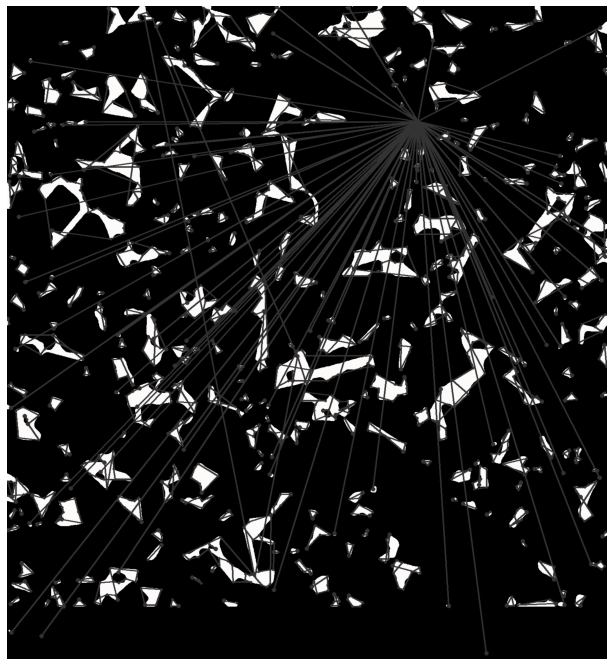

In [158]:
img2=draw_edges(image2,new_nodes,grain2_corners)
img_show(img2,cmap='gray',N=12)
#io.imsave('vals.png',img2)